# Data Wrangling Twitter "We Rate Dogs"

In [1]:
#load libraries
import pandas as pd
import requests
import glob, os
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import configparser
import re
import dataframe_image as dfi
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sms
%matplotlib inline

In [2]:
#set pandas to display all content
pd.set_option('display.max_colwidth', None)

## Gather

In [3]:
#read twitter archive
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None


In [4]:
#download in image_predictions.tsv
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
with open(os.path.join(os.path.curdir, url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)

In [5]:
#check if file is available
for file in glob.glob("*.tsv"):
    print(file)

image-predictions.tsv


In [6]:
#load image predictions
image_predictions = pd.read_csv('image-predictions.tsv', sep='\t')
image_predictions.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


In [7]:
#Access twitter data via API
config = configparser.ConfigParser()
config.read('./twitter/config.ini')

consumer_key = config['Twitter']['consumer_key']
consumer_secret = config['Twitter']['consumer_secret']
access_token = config['Twitter']['access_token']
access_secret = config['Twitter']['access_secret']

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, retry_errors=set([401, 404, 500, 502, 503, 504]))
    
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for key, tweet_id in twitter_archive.tweet_id.items():
        
        print(str(key+1) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

Fail
262: 842846295480000512
Success
263: 842765311967449089
Success
264: 842535590457499648
Success
265: 842163532590374912
Success
266: 842115215311396866
Success
267: 841833993020538882
Success
268: 841680585030541313
Success
269: 841439858740625411
Success
270: 841320156043304961
Success
271: 841314665196081154
Success
272: 841077006473256960
Success
273: 840761248237133825
Success
274: 840728873075638272
Success
275: 840698636975636481
Success
276: 840696689258311684
Success
277: 840632337062862849
Success
278: 840370681858686976
Success
279: 840268004936019968
Success
280: 839990271299457024
Success
281: 839549326359670784
Success
282: 839290600511926273
Success
283: 839239871831150596
Success
284: 838952994649550848
Success
285: 838921590096166913
Success
286: 838916489579200512
Success
287: 838831947270979586
Success
288: 838561493054533637
Success
289: 838476387338051585
Success
290: 838201503651401729
Success
291: 838150277551247360
Success
292: 838085839343206401
Success
293

Success
519: 810657578271330305
Success
520: 810284430598270976
Success
521: 810254108431155201
Success
522: 809920764300447744
Success
523: 809808892968534016
Success
524: 809448704142938112
Success
525: 809220051211603969
Success
526: 809084759137812480
Success
527: 808838249661788160
Success
528: 808733504066486276
Success
529: 808501579447930884
Success
530: 808344865868283904
Success
531: 808134635716833280
Success
532: 808106460588765185
Success
533: 808001312164028416
Success
534: 807621403335917568
Success
535: 807106840509214720
Success
536: 807059379405148160
Success
537: 807010152071229440
Success
538: 806629075125202948
Success
539: 806620845233815552
Success
540: 806576416489959424
Success
541: 806542213899489280
Success
542: 806242860592926720
Success
543: 806219024703037440
Success
544: 805958939288408065
Success
545: 805932879469572096
Success
546: 805826884734976000
Success
547: 805823200554876929
Success
548: 805520635690676224
Success
549: 805487436403003392
Success


Success
776: 776201521193218049
Success
777: 776113305656188928
Success
778: 776088319444877312
Success
779: 775898661951791106
Success
780: 775842724423557120
Success
781: 775733305207554048
Success
782: 775729183532220416
Success
783: 775364825476165632
Success
784: 775350846108426240
Success
785: 775096608509886464
Fail
786: 775085132600442880
Success
787: 774757898236878852
Success
788: 774639387460112384
Success
789: 774314403806253056
Success
790: 773985732834758656
Success
791: 773922284943896577
Success
792: 773704687002451968
Success
793: 773670353721753600
Success
794: 773547596996571136
Success
795: 773336787167145985
Success
796: 773308824254029826
Success
797: 773247561583001600
Success
798: 773191612633579521
Success
799: 772877495989305348
Success
800: 772826264096874500
Success
801: 772615324260794368
Success
802: 772581559778025472
Success
803: 772193107915964416
Success
804: 772152991789019136
Success
805: 772117678702071809
Success
806: 772114945936949249
Success
807

Success
1032: 745422732645535745
Success
1033: 745314880350101504
Success
1034: 745074613265149952
Success
1035: 745057283344719872
Success
1036: 744995568523612160
Success
1037: 744971049620602880
Success
1038: 744709971296780288
Success
1039: 744334592493166593
Success
1040: 744234799360020481
Success
1041: 744223424764059648
Success
1042: 743980027717509120
Success
1043: 743895849529389061
Success
1044: 743835915802583040
Success
1045: 743609206067040256
Success
1046: 743595368194129920
Success
1047: 743545585370791937
Success
1048: 743510151680958465
Success
1049: 743253157753532416
Success
1050: 743222593470234624
Success
1051: 743210557239623680
Success
1052: 742534281772302336
Success
1053: 742528092657332225
Success
1054: 742465774154047488
Success
1055: 742423170473463808
Success
1056: 742385895052087300
Success
1057: 742161199639494656
Success
1058: 742150209887731712
Success
1059: 741793263812808706
Success
1060: 741743634094141440
Success
1061: 741438259667034112
Success
10

Success
1281: 708834316713893888
Success
1282: 708810915978854401
Success
1283: 708738143638450176
Success
1284: 708711088997666817
Success
1285: 708479650088034305
Success
1286: 708469915515297792
Success
1287: 708400866336894977
Success
1288: 708356463048204288
Success
1289: 708349470027751425
Success
1290: 708149363256774660
Success
1291: 708130923141795840
Success
1292: 708119489313951744
Success
1293: 708109389455101952
Success
1294: 708026248782585858
Success
1295: 707995814724026368
Success
1296: 707983188426153984
Success
1297: 707969809498152960
Success
1298: 707776935007539200
Success
1299: 707741517457260545
Success
1300: 707738799544082433
Success
1301: 707693576495472641
Success
1302: 707629649552134146
Success
1303: 707610948723478529
Success
1304: 707420581654872064
Success
1305: 707411934438625280
Success
1306: 707387676719185920
Success
1307: 707377100785885184
Success
1308: 707315916783140866
Success
1309: 707297311098011648
Success
1310: 707059547140169728
Success
13

Success
1530: 690248561355657216
Success
1531: 690021994562220032
Success
1532: 690015576308211712
Success
1533: 690005060500217858
Success
1534: 689999384604450816
Success
1535: 689993469801164801
Success
1536: 689977555533848577
Success
1537: 689905486972461056
Success
1538: 689877686181715968
Success
1539: 689835978131935233
Success
1540: 689661964914655233
Success
1541: 689659372465688576
Success
1542: 689623661272240129
Success
1543: 689599056876867584
Success
1544: 689557536375177216
Success
1545: 689517482558820352
Success
1546: 689289219123089408
Success
1547: 689283819090870273
Success
1548: 689280876073582592
Success
1549: 689275259254616065
Success
1550: 689255633275777024
Success
1551: 689154315265683456
Success
1552: 689143371370250240
Success
1553: 688916208532455424
Success
1554: 688908934925697024
Success
1555: 688898160958271489
Success
1556: 688894073864884227
Success
1557: 688828561667567616
Success
1558: 688804835492233216
Success
1559: 688789766343622656
Success
15

Success
1779: 677895101218201600
Success
1780: 677716515794329600
Success
1781: 677700003327029250
Success
1782: 677698403548192770
Success
1783: 677687604918272002
Success
1784: 677673981332312066
Success
1785: 677662372920729601
Success
1786: 677644091929329666
Success
1787: 677573743309385728
Success
1788: 677565715327688705
Success
1789: 677557565589463040
Success
1790: 677547928504967168
Success
1791: 677530072887205888
Success
1792: 677335745548390400
Success
1793: 677334615166730240
Success
1794: 677331501395156992
Success
1795: 677328882937298944
Success
1796: 677314812125323265
Success
1797: 677301033169788928
Success
1798: 677269281705472000
Success
1799: 677228873407442944
Success
1800: 677187300187611136
Success
1801: 676975532580409345
Success
1802: 676957860086095872
Success
1803: 676949632774234114
Success
1804: 676948236477857792
Success
1805: 676946864479084545
Success
1806: 676942428000112642
Success
1807: 676936541936185344
Success
1808: 676916996760600576
Success
18

Success
2028: 671874878652489728
Success
2029: 671866342182637568
Success
2030: 671855973984772097
Success
2031: 671789708968640512
Success
2032: 671768281401958400
Success
2033: 671763349865160704
Success
2034: 671744970634719232
Success
2035: 671743150407421952
Success
2036: 671735591348891648
Success
2037: 671729906628341761
Success
2038: 671561002136281088
Success
2039: 671550332464455680
Success
2040: 671547767500775424
Success
2041: 671544874165002241
Success
2042: 671542985629241344
Success
2043: 671538301157904385
Success
2044: 671536543010570240
Success
2045: 671533943490011136
Success
2046: 671528761649688577
Success
2047: 671520732782923777
Success
2048: 671518598289059840
Success
2049: 671511350426865664
Success
2050: 671504605491109889
Success
2051: 671497587707535361
Success
2052: 671488513339211776
Success
2053: 671486386088865792
Success
2054: 671485057807351808
Success
2055: 671390180817915904
Success
2056: 671362598324076544
Success
2057: 671357843010908160
Success
20

Success
2277: 667443425659232256
Success
2278: 667437278097252352
Success
2279: 667435689202614272
Success
2280: 667405339315146752
Success
2281: 667393430834667520
Success
2282: 667369227918143488
Success
2283: 667211855547486208
Success
2284: 667200525029539841
Success
2285: 667192066997374976
Success
2286: 667188689915760640
Success
2287: 667182792070062081
Success
2288: 667177989038297088
Success
2289: 667176164155375616
Success
2290: 667174963120574464
Success
2291: 667171260800061440
Success
2292: 667165590075940865
Success
2293: 667160273090932737
Success
2294: 667152164079423490
Success
2295: 667138269671505920
Success
2296: 667119796878725120
Success
2297: 667090893657276420
Success
2298: 667073648344346624
Success
2299: 667070482143944705
Success
2300: 667065535570550784
Success
2301: 667062181243039745
Success
2302: 667044094246576128
Success
2303: 667012601033924608
Success
2304: 666996132027977728
Success
2305: 666983947667116034
Success
2306: 666837028449972224
Success
23

In [8]:
#number of failed ids
len(fails_dict)

25

In [9]:
#get failure reason for failed ids
for key, value in fails_dict.items():
    print(key, value)

888202515573088257 [{'code': 144, 'message': 'No status found with that ID.'}]
873697596434513921 [{'code': 144, 'message': 'No status found with that ID.'}]
872668790621863937 [{'code': 144, 'message': 'No status found with that ID.'}]
872261713294495745 [{'code': 144, 'message': 'No status found with that ID.'}]
869988702071779329 [{'code': 144, 'message': 'No status found with that ID.'}]
866816280283807744 [{'code': 144, 'message': 'No status found with that ID.'}]
861769973181624320 [{'code': 144, 'message': 'No status found with that ID.'}]
856602993587888130 [{'code': 144, 'message': 'No status found with that ID.'}]
851953902622658560 [{'code': 144, 'message': 'No status found with that ID.'}]
845459076796616705 [{'code': 144, 'message': 'No status found with that ID.'}]
844704788403113984 [{'code': 144, 'message': 'No status found with that ID.'}]
842892208864923648 [{'code': 144, 'message': 'No status found with that ID.'}]
837366284874571778 [{'code': 144, 'message': 'No sta

In [10]:
#let's have a look at the failed downloads
valuelist = list(fails_dict.keys())
twitter_archive[twitter_archive.tweet_id.isin(valuelist)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1",13,10,Canela,None,None,None,None
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Walter. He won't start hydrotherapy without his favorite floatie. 14/10 keep it pup Walter https://t.co/r28jFx9uyF,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,"https://twitter.com/dog_rates/status/868880397819494401/photo/1,https://twitter.com/dog_rates/status/868880397819494401/photo/1",14,10,Walter,None,None,None,None
101,872668790621863937,NaN,NaN,2017-06-08 04:17:07 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @loganamnosis: Penelope here is doing me quite a divertir. Well done, @dog_rates! Loving the pupdate. 14/10, je jouerais de nouveau. htt…",8.726576e+17,1.547674e+08,2017-06-08 03:32:35 +0000,https://twitter.com/loganamnosis/status/872657584259551233/photo/1,14,10,None,None,None,None,None
104,872261713294495745,NaN,NaN,2017-06-07 01:19:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Harry. His ears are activated one at a time. Incredibly rare to witness in person. Very special moment here. 13/10 blessed as h*ck https://t.co/ejHvGDfWoa,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/872261713294495745/photo/1,https://twitter.com/dog_rates/status/872261713294495745/photo/1",13,10,Harry,None,None,None,None
118,869988702071779329,NaN,NaN,2017-05-31 18:47:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10…,8.591970e+17,4.196984e+09,2017-05-02 00:04:57 +0000,https://twitter.com/dog_rates/status/859196978902773760/video/1,12,10,quite,None,None,None,None
132,866816280283807744,NaN,NaN,2017-05-23 00:41:20 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: This is Jamesy. He gives a kiss to every other pupper he sees on his walk. 13/10 such passion, much tender https://t.co/wk7T…",8.664507e+17,4.196984e+09,2017-05-22 00:28:40 +0000,"https://twitter.com/dog_rates/status/866450705531457537/photo/1,https://twitter.com/dog_rates/status/866450705531457537/photo/1",13,10,Jamesy,None,None,pupper,None
155,861769973181624320,NaN,NaN,2017-05-09 02:29:07 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: ""Good afternoon class today we're going to learn what makes a good boy so good"" 13/10 https://t.co/f1h2Fsalv9",8.066291e+17,4.196984e+09,2016-12-07 22:38:52 +0000,"https://twitter.com/dog_rates/status/806629075125202948/photo/1,https://twitter.com/dog_rates/status/806629075125202948/photo/1,https://twitter.com/dog_rates/status/806629075125202948/photo/1,https://twitter.com/dog_rates/status/806629075125202948/photo/1",13,10,None,None,None,None,None
182,856602993587888130,NaN,NaN,2017-04-24 20:17:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is

Assumption: some tweed ids are wrong - let's have a look at this when assessing

In [11]:
#load JSON file into dataframe
tweet_data = pd.read_json(r'tweet_json.txt', lines=True, dtype={}) 
tweet_data.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336193,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'url': 'https://t.co/MgUWQ76dJU', 'display_url': 'pic.twitter.com/MgUWQ76dJU', 'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'medium': {'w': 540, 'h': 528, 'resize': 'fit'}, 'small': {'w': 540, 'h': 528, 'resize': 'fit'}, 'large': {'w': 540, 'h': 528, 'resize': 'fit'}}}]}","{'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'url': 'https://t.co/MgUWQ76dJU', 'display_url': 'pic.twitter.com/MgUWQ76dJU', 'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'medium': {'w': 540, 'h': 528, 'resize': 'fit'}, 'small': {'w': 540, 'h': 528, 'resize': 'fit'}, 'large': {'w': 540, 'h': 528, 'resize': 'fit'}}}]}","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343426,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892177413194625024, 'id_str': '892177413194625024', 'indices': [139, 162], 'media_url': 'http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg', 'url': 'https://t.co/0Xxu71qeIV', 'display_url': 'pic.twitter.com/0Xxu71qeIV', 'expanded_url': 'https://twitter.com/dog_rates/status/892177421306343426/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'medium': {'w': 1055, 'h': 1200, 'resize': 'fit'}, 'small': {'w': 598, 'h': 680, 'resize': 'fit'}, 'large': {'w': 1407, 'h': 1600, 'resize': 'fit'}}}]}","{'media': [{'id': 892177413194625024, 'id_str': '892177413194625024', 'indices': [139, 162], 'media_url': 'http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg', 'url': 'https://t.co/0Xxu71qeIV', 'display_url': 'pic.twitter.com/0Xxu71qeIV', 'expanded_url': 'https://twitter.com/dog_rates/status/892177421306343426/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'medium': {'w': 1055, 'h': 1200, 'resize': 'fit'}, 'small': {'w': 598, 'h': 680, 'resize': 'fit'}, 'large': {'w': 1407, 'h': 1600, 'resize': 'fit'}}}]}","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 891815175371796480, 'id_str': '891815175371796480', 'indices': [122, 145], 'media_

## Assess

### Data Scheme Information

#### Desciption of tweet_data fields
`tweet data` fields are desribed [here](https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet)

#### Description of Image Prediction Data (according to Udacity workspace)
  
|field name  | description | example |
|---|:---|:---|
| `tweet_id` | is the last part of the tweet URL after "status/" | https://twitter.com/dog_rates/status/889531135344209921 |
| `p1` | is the algorithm's #1 prediction for the image in the tweet | golden retriever |
| `p1_conf`| is how confident the algorithm is in its #1 prediction | 95% |
| `p1_dog` | is whether or not the #1 prediction is a breed of dog | TRUE |
| `p2`|  is the algorithm's second most likely prediction | Labrador retriever |
| `p2_conf`| is how confident the algorithm is in its #2 prediction | 1% |
| `p2_dog` | is whether or not the #2 prediction is a breed of dog | TRUE |



### Assess Twitter Archive

In [12]:
#get a first view on the table
twitter_archive.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None


In [13]:
#look at the info
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [14]:
#check for duplicates
len(twitter_archive[twitter_archive.duplicated()])

0

Now care for failed tweed downloads - according to the error message, sometimes tweets doesn't exist for the id.
Tweed ids should match those tweet_ids in expanded_urls column
Let's have a look at it.

In [15]:
wrong_tweets = twitter_archive[twitter_archive.apply(lambda x: str(x['tweet_id']) not in str(x['expanded_urls']), axis=1)][['tweet_id', 'expanded_urls']]
wrong_tweets = wrong_tweets[~wrong_tweets.expanded_urls.isnull()& wrong_tweets.expanded_urls.str.contains(r'.*\d{18}.*')]
wrong_tweets

,tweet_id,expanded_urls
19,888202515573088257,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1"
32,886054160059072513,"https://twitter.com/dog_rates/status/886053434075471873,https://twitter.com/dog_rates/status/886053434075471873"
35,885518971528720385,https://twitter.com/4bonds2carbon/status/885517367337512960
36,885311592912609280,"https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1"
42,884247878851493888,https://twitter.com/kaijohnson_19/status/883965650754039809
...,...,...
1237,712309440758808576,https://twitter.com/stickergrub/status/709919141004595201
1242,711998809858043904,"https://twitter.com/twitter/status/711998279773347841/photo/1,https://twitter.com/twitter/status/711998279773347841/photo/1"
1324,706169069255446529,https://twitter.com/wgnnews/status/706165920809492480
2259,667550904950915073,"https://twitter.com/dogratingrating/status/667548695664070656/photo/1,https://twitter.com/dogratingrating/status/667548695664070656/photo/1"


In [16]:
#look for null values in expanded_urls
twitter_archive[twitter_archive.expanded_urls.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10",NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Jenna_Marbles: @dog_rates Thanks for rating my cermets 14/10 wow I'm so proud I watered them so much,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@xianmcguire @Jenna_Marbles Kardashians wouldn't be famous if as a society we didn't place enormous value on what they do. The dogs are very deserving of their 14/10,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


In [17]:
#look at rating numerator values
twitter_archive.rating_numerator.value_counts().sort_index()

0         2
1         9
2         9
3        19
4        17
5        37
6        32
7        55
8       102
9       158
10      461
11      464
12      558
13      351
14       54
15        2
17        1
20        1
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        2
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
182       1
204       1
420       2
666       1
960       1
1776      1
Name: rating_numerator, dtype: int64

In [18]:
#look at suspicious rating numerator values
twitter_archive.query('(rating_numerator >= 15) or (rating_numerator <= 6)')[['tweet_id', 'text', 'rating_numerator']]

,tweet_id,text,rating_numerator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5
55,881633300179243008,@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,17
188,855862651834028034,@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,420
189,855860136149123072,"@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",666
229,848212111729840128,"This is Jerry. He's doing a distinguished tongue slip. Slightly patronizing tbh. You think you're better than us, Jerry? 6/10 hold me back https://t.co/DkOBbwulw1",6
...,...,...,...
2338,666104133288665088,Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/Asgdc6kuLX,1
2342,666082916733198337,Here we have a well-established sunblockerspaniel. Lost his other flip-flop. 6/10 not very waterproof https://t.co/3RU6x0vHB7,6
2349,666051853826850816,This is an odd dog. Hard on the outside but loving on the inside. Petting still fun. Doesn't play catch well. 2/10 https://t.co/v5A4vzSDdc,2
2351,666049248165822465,Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,5


In [19]:
#rating denominator is normally 10 ... look at values != 10

twitter_archive.query('rating_denominator != 10')[['tweet_id', 'text', 'rating_denominator', 'rating_numerator']]

,tweet_id,text,rating_denominator,rating_numerator
313,835246439529840640,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",0,960
342,832088576586297345,@docmisterio account started on 11/15/15,15,11
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,70,84
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \r\nKeep Sam smiling by clicking and sharing this link:\r\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,7,24
784,775096608509886464,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",11,9
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,150,165
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",11,9
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,170,204
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,20,4
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50


In [20]:
#find retweets and replies
twitter_archive.query('(~retweeted_status_user_id.isnull()) or (~in_reply_to_status_id.isnull())')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1",13,10,Canela,None,None,None,None
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Athletics: 12/10 #BATP https://t.co/WxwJmvjfxo,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,"https://twitter.com/dog_rates/status/886053434075471873,https://twitter.com/dog_rates/status/886053434075471873",12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well https://t.co/SATN4If5H5,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,"https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1",13,10,Lilly,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2169,669353438988365824,6.678065e+17,4.196984e+09,2015-11-25 03:14:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Tessa. She is also very pleased after finally meeting her biological father. 10/10 https://t.co/qDS1aCqppv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669353438988365824/photo/1,10,10,Tessa,None,None,None,None
2189,668967877119254528,6.689207e+17,2.143566e+07,2015-11-24 01:42:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",12/10 good shit Bubka\r\n@wane15,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
2259,667550904950915073,NaN,NaN,2015-11-20 03:51:52 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>","RT @dogratingrating: Exceptional talent. Original humor. Cutting edge, Nova Scotian comedian. 12/10 https://t.co/uarnTjBeVA",6.675487e+17,4.296832e+09,2015-11-20 03:43:06 +0000,"https://twitter.com/dogratingrating/status/667548695664070656/photo/1,https://twitter.com/dogratingrating/status/667548695664070656/photo/1",12,10,None,None,None,None,None
2260,667550882905632768,NaN,NaN,2015-11-20 03:51:47 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",RT @dogratingrating: Unoriginal idea. Blatant plagiarism. Curious grammar. -5/10 https://t.co/r7XzeQZWzb,6.675484e+17,4.296832e+09,2015-11-20 03:41:59 +0000,"https://twitter.com/dogratingrating/s

### Assess Downloaded Tweet Data

In [21]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2331 non-null   datetime64[ns, UTC]
 1   id                             2331 non-null   int64              
 2   id_str                         2331 non-null   object             
 3   full_text                      2331 non-null   object             
 4   truncated                      2331 non-null   bool               
 5   display_text_range             2331 non-null   object             
 6   entities                       2331 non-null   object             
 7   extended_entities              2059 non-null   object             
 8   source                         2331 non-null   object             
 9   in_reply_to_status_id          77 non-null     float64            
 10  in_reply_to_status_id_st

In [22]:
#have a look at the table
tweet_data.head(1)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336193,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'url': 'https://t.co/MgUWQ76dJU', 'display_url': 'pic.twitter.com/MgUWQ76dJU', 'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'medium': {'w': 540, 'h': 528, 'resize': 'fit'}, 'small': {'w': 540, 'h': 528, 'resize': 'fit'}, 'large': {'w': 540, 'h': 528, 'resize': 'fit'}}}]}","{'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'url': 'https://t.co/MgUWQ76dJU', 'display_url': 'pic.twitter.com/MgUWQ76dJU', 'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'medium': {'w': 540, 'h': 528, 'resize': 'fit'}, 'small': {'w': 540, 'h': 528, 'resize': 'fit'}, 'large': {'w': 540, 'h': 528, 'resize': 'fit'}}}]}","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN


In [23]:
#have a look at the user field
tweet_data.head(1)['user']

0    {'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs®', 'screen_name': 'dog_rates', 'location': 'links and things ➜', 'description': 'Your Only Source For Professional Dog Ratings Instagram and Facebook ➜ WeRateDogs partnerships@weratedogs.com ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀', 'url': 'https://t.co/hADNnRWmP3', 'entities': {'url': {'urls': [{'url': 'https://t.co/hADNnRWmP3', 'expanded_url': 'http://campsite.bio/weratedogs', 'display_url': 'campsite.bio/weratedogs', 'indices': [0, 23]}]}, 'description': {'urls': []}}, 'protected': False, 'followers_count': 9022730, 'friends_count': 18, 'listed_count': 6637, 'created_at': 'Sun Nov 15 21:41:29 +0000 2015', 'favourites_count': 145403, 'utc_offset': None, 'time_zone': None, 'geo_enabled': True, 'verified': True, 'statuses_count': 13799, 'lang': None, 'contributors_enabled': False, 'is_translator': False, 'is_translation_enabled': False, 'profile_background_color': '000000', 'profile_background_image_url': 'http://abs.twimg.com/images/themes/them

In [24]:
#what's inside entities?
print(tweet_data[tweet_data['id'] == 668623201287675904]['entities'])

2184    {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 668623188582989824, 'id_str': '668623188582989824', 'indices': [74, 97], 'media_url': 'http://pbs.twimg.com/media/CUdtP1wUAAAzwKY.jpg', 'media_url_https': 'https://pbs.twimg.com/media/CUdtP1wUAAAzwKY.jpg', 'url': 'https://t.co/TIhVKEIPqj', 'display_url': 'pic.twitter.com/TIhVKEIPqj', 'expanded_url': 'https://twitter.com/dog_rates/status/668623201287675904/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'small': {'w': 510, 'h': 680, 'resize': 'fit'}, 'medium': {'w': 720, 'h': 960, 'resize': 'fit'}, 'large': {'w': 720, 'h': 960, 'resize': 'fit'}}}]}
Name: entities, dtype: object


In [25]:
#what's inside extended entities?
print(tweet_data[tweet_data['id'] == 668623201287675904]['extended_entities'])

2184    {'media': [{'id': 668623188582989824, 'id_str': '668623188582989824', 'indices': [74, 97], 'media_url': 'http://pbs.twimg.com/media/CUdtP1wUAAAzwKY.jpg', 'media_url_https': 'https://pbs.twimg.com/media/CUdtP1wUAAAzwKY.jpg', 'url': 'https://t.co/TIhVKEIPqj', 'display_url': 'pic.twitter.com/TIhVKEIPqj', 'expanded_url': 'https://twitter.com/dog_rates/status/668623201287675904/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'small': {'w': 510, 'h': 680, 'resize': 'fit'}, 'medium': {'w': 720, 'h': 960, 'resize': 'fit'}, 'large': {'w': 720, 'h': 960, 'resize': 'fit'}}}, {'id': 668623188566257664, 'id_str': '668623188566257664', 'indices': [74, 97], 'media_url': 'http://pbs.twimg.com/media/CUdtP1sUsAAWi1E.jpg', 'media_url_https': 'https://pbs.twimg.com/media/CUdtP1sUsAAWi1E.jpg', 'url': 'https://t.co/TIhVKEIPqj', 'display_url': 'pic.twitter.com/TIhVKEIPqj', 'expanded_url': 'https://twitter.com/dog_rates/status/668623201287675904/photo/1', 'type': 

### Assess Image Predictions Data

In [26]:
#look at the data
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [27]:
#look for prediction values above 1 and below 0 and suspicious img_num values
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [28]:
#look for duplicated entries
image_predictions[image_predictions.tweet_id.duplicated()].shape[0]

0

In [29]:
#look for strange dtypes and null values
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [30]:
#find duplicated columns in data
all_columns = pd.Series(list(tweet_data) + list(twitter_archive) + list(image_predictions))
all_columns[all_columns.duplicated()]

33    in_reply_to_status_id
34      in_reply_to_user_id
36                   source
49                 tweet_id
dtype: object

### Findings

#### Quality
##### `image_predictions` table
- non-speaking column names  ***won't fix***
    * img_num -> number_of_images
    * p1 -> image_prediction1
    * p1_conf -> prediction1_confidence
    * p1_dog -> prediction1_dog
    
##### `twitter_archive` table
- missing Values in expanded_urls
- implausible rating_numerator values
    * parsing errors like in tweet_id 883482846933004288 (dot isn't parsed)
    * multiple parallel ratings like in tweet_id 758467244762497024
- rating_denominator values > 10
    * parsing errors like in tweet_id 740373189193256964
    * multiple parallel ratings like in tweet_id 731156023742988288
- Erroneous datatypes (in_reply_to_status_id, in_reply_to_user_id, timestamp, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp)
- not all entries are original ratings (no retweets) that have images
- wrong tweet ids

##### `tweet_data` table
- Columns without values (contributors, coordinates, geo)
- place only has a single value
- not all entries are original ratings (no retweets) that have images
- Erroneous datatypes - in_reply_to_status_id, in_reply_to_user_id, lang

#### Tidiness
- One variable in `twitter_archive` in 4 columns (dog_stage instead of doggo, floofer, pupper, puppo)
- Tweet_type variable (initial_tweet, retweet, reply) missing in `tweet_data` and `twitter_archive` table ***won't fix because we're going to delete this informaion on deleting retweets...***
    - Information about retweets and replies should be in separate table
        * retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, in_reply_to_status_id, in_reply_to_user_id
- `tweet_data` should be part of `twitter_archive`
- duplicate information in columns id and id_str in `tweet_data`
- information of entities is also contained in extended_entities in `tweet_data` ***won't fix***
- user, entities and extended_entities in `tweet_data` include multiple different variables, should be in separate tables ***won't fix***
- display_text_range in `tweet_data` contains two variables (start of displayed text, end of displayed text) ***won't fix***
- tweet_id columns in tweet_data has different name (id)
- `image_predictions`should be part of `twitter_archive`
- Tweet timestamps have different column names and formats in `tweet data` and `twitter archive`

## Clean

In [31]:
twitter_archive_clean = twitter_archive.copy()
tweet_data_clean = tweet_data.copy()
image_predictions_clean = image_predictions.copy()

#### Define

Remove Columns without or with few values in tweet_data_clean table "contributors, coordinates, geo, place"

#### Code

In [32]:
tweet_data_clean.drop(['contributors', 'coordinates', 'geo', 'place' ], axis=1, inplace=True)

In [33]:
#confirm columns are gone
list(tweet_data_clean)

['created_at',
 'id',
 'id_str',
 'full_text',
 'truncated',
 'display_text_range',
 'entities',
 'extended_entities',
 'source',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'in_reply_to_screen_name',
 'user',
 'is_quote_status',
 'retweet_count',
 'favorite_count',
 'favorited',
 'retweeted',
 'possibly_sensitive',
 'possibly_sensitive_appealable',
 'lang',
 'retweeted_status',
 'quoted_status_id',
 'quoted_status_id_str',
 'quoted_status_permalink',
 'quoted_status']

#### Define

Rename ID column in and delete tweet_data_clean and drop id_str

#### Code

In [34]:
tweet_data_clean.rename(columns={"id": "tweet_id"}, inplace=True)
tweet_data_clean.drop(['id_str' ], axis=1, inplace=True)

#### Test

In [35]:
list(tweet_data_clean)

['created_at',
 'tweet_id',
 'full_text',
 'truncated',
 'display_text_range',
 'entities',
 'extended_entities',
 'source',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'in_reply_to_screen_name',
 'user',
 'is_quote_status',
 'retweet_count',
 'favorite_count',
 'favorited',
 'retweeted',
 'possibly_sensitive',
 'possibly_sensitive_appealable',
 'lang',
 'retweeted_status',
 'quoted_status_id',
 'quoted_status_id_str',
 'quoted_status_permalink',
 'quoted_status']

#### Define

Creating a new column 'dog_stage' merging the existing columns 'doggo', 'floofer', 'pupper' and 'puppo'  using pandas apply function. After merging delete old columns.

#### Code

In [36]:
dog_stagefields = ['doggo', 'floofer', 'pupper', 'puppo']

def getDogStage(tweet):
    for entry in dog_stagefields:
        if tweet[entry] != 'None':
            return tweet[entry]
    return 'None'

twitter_archive_clean['dog_stage'] = twitter_archive_clean.apply(getDogStage, axis=1)

twitter_archive_clean.drop(dog_stagefields, axis=1, inplace=True)

#### Test

In [37]:
twitter_archive_clean.dog_stage.value_counts()

None       1976
pupper      245
doggo        97
puppo        29
floofer       9
Name: dog_stage, dtype: int64

In [38]:
list(twitter_archive_clean)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'dog_stage']

#### Define

Correct datatypes in `twitter_archive_clean`
   * timestamp to date
   * dog_stage to categorical
   * don't care for reply and retweeted columns - going to delete them later
    
Correct datatypes in `tweet_data_clean`
   * don't care for reply, retweeted, and quotes columns - going to delete them later
   * lang to categorical   

#### Code

In [39]:
twitter_archive_clean['dog_stage'] = twitter_archive_clean.dog_stage.astype('category')

In [40]:
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean.timestamp)

In [41]:
tweet_data_clean['lang'] = tweet_data_clean.lang.astype('category')

#### Test

In [42]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   int64              
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

In [43]:
tweet_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2331 non-null   datetime64[ns, UTC]
 1   tweet_id                       2331 non-null   int64              
 2   full_text                      2331 non-null   object             
 3   truncated                      2331 non-null   bool               
 4   display_text_range             2331 non-null   object             
 5   entities                       2331 non-null   object             
 6   extended_entities              2059 non-null   object             
 7   source                         2331 non-null   object             
 8   in_reply_to_status_id          77 non-null     float64            
 9   in_reply_to_status_id_str      77 non-null     object             
 10  in_reply_to_user_id     

#### Define

Merge tweet_data_clean into twitter_archive_clean using pandas merge on tweet_id.

#### Code

In [44]:
twitter_archive_clean = pd.merge(twitter_archive_clean, tweet_data_clean,
                            on=['tweet_id'], how='left')

#### Test

In [45]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   tweet_id                       2356 non-null   int64              
 1   in_reply_to_status_id_x        78 non-null     float64            
 2   in_reply_to_user_id_x          78 non-null     float64            
 3   timestamp                      2356 non-null   datetime64[ns, UTC]
 4   source_x                       2356 non-null   object             
 5   text                           2356 non-null   object             
 6   retweeted_status_id            181 non-null    float64            
 7   retweeted_status_user_id       181 non-null    float64            
 8   retweeted_status_timestamp     181 non-null    object             
 9   expanded_urls                  2297 non-null   object             
 10  rating_numerator        

#### Define

Merge image_predictions_clean into twitter_archive_clean using pandas merge on tweet_id.

#### Code

In [46]:
twitter_archive_clean = pd.merge(twitter_archive_clean, image_predictions_clean,
                            on=['tweet_id'], how='left')

#### Test

In [47]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   tweet_id                       2356 non-null   int64              
 1   in_reply_to_status_id_x        78 non-null     float64            
 2   in_reply_to_user_id_x          78 non-null     float64            
 3   timestamp                      2356 non-null   datetime64[ns, UTC]
 4   source_x                       2356 non-null   object             
 5   text                           2356 non-null   object             
 6   retweeted_status_id            181 non-null    float64            
 7   retweeted_status_user_id       181 non-null    float64            
 8   retweeted_status_timestamp     181 non-null    object             
 9   expanded_urls                  2297 non-null   object             
 10  rating_numerator        

#### Define

Delete all retweets, quotes, replies by filtering on 

* quoted_status_id is null
* retweeted_status is null
* retweeted_status_id is null
* in_reply_to_status_id_y(+x) is null. 
* is_quote_status is False or None
* retweeted is False or None

#### Code

In [48]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.quoted_status_id.isnull() 
                      & twitter_archive_clean.retweeted_status.isnull()
                        & twitter_archive_clean.retweeted_status_id.isnull()
                          & twitter_archive_clean.retweeted_status_id.isnull()
                           & twitter_archive_clean.in_reply_to_status_id_y.isnull()
                             & twitter_archive_clean.in_reply_to_status_id_x.isnull()
                                & (twitter_archive_clean.is_quote_status.isnull() | twitter_archive_clean.is_quote_status == False)
                                  & (twitter_archive_clean.retweeted.isnull() | twitter_archive_clean.retweeted_status == False)]

#### Test

In [49]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2061 entries, 0 to 2355
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   tweet_id                       2061 non-null   int64              
 1   in_reply_to_status_id_x        0 non-null      float64            
 2   in_reply_to_user_id_x          0 non-null      float64            
 3   timestamp                      2061 non-null   datetime64[ns, UTC]
 4   source_x                       2061 non-null   object             
 5   text                           2061 non-null   object             
 6   retweeted_status_id            0 non-null      float64            
 7   retweeted_status_user_id       0 non-null      float64            
 8   retweeted_status_timestamp     0 non-null      object             
 9   expanded_urls                  2058 non-null   object             
 10  rating_numerator        

In [50]:
twitter_archive_clean.is_quote_status.value_counts(), twitter_archive_clean.retweeted.value_counts()

(False    2061
 Name: is_quote_status, dtype: int64,
 False    2061
 Name: retweeted, dtype: int64)

#### Define

Delete all columns for replies, retweets and quotes.

#### Code

In [51]:
def getfields(df, exp):
    return_list = []
    for entry in exp:
        return_list += list(df.filter(regex=entry))
    return return_list

droplist_none_originals = getfields(twitter_archive_clean, ['in_reply_to', 'retweeted', 'quote'])
droplist_none_originals

['in_reply_to_status_id_x',
 'in_reply_to_user_id_x',
 'in_reply_to_status_id_y',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id_y',
 'in_reply_to_user_id_str',
 'in_reply_to_screen_name',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'retweeted',
 'retweeted_status',
 'is_quote_status',
 'quoted_status_id',
 'quoted_status_id_str',
 'quoted_status_permalink',
 'quoted_status']

In [52]:
twitter_archive_clean.drop(droplist_none_originals, axis=1, inplace=True)

#### Test

In [53]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2061 entries, 0 to 2355
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   tweet_id                       2061 non-null   int64              
 1   timestamp                      2061 non-null   datetime64[ns, UTC]
 2   source_x                       2061 non-null   object             
 3   text                           2061 non-null   object             
 4   expanded_urls                  2058 non-null   object             
 5   rating_numerator               2061 non-null   int64              
 6   rating_denominator             2061 non-null   int64              
 7   name                           2061 non-null   object             
 8   dog_stage                      2061 non-null   category           
 9   created_at                     2061 non-null   datetime64[ns, UTC]
 10  full_text               

#### Define

Compare `timestamp` column with `created_at` column. Merge if necessary. Drop `created_at` if identical.

#### Code

In [54]:
#compare both timestamps
twitter_archive_clean[twitter_archive_clean.timestamp != twitter_archive_clean.created_at][['timestamp','created_at']]

,timestamp,created_at


In [55]:
twitter_archive_clean.drop(['created_at'], axis=1, inplace=True)

#### Test

In [56]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2061 entries, 0 to 2355
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   tweet_id                       2061 non-null   int64              
 1   timestamp                      2061 non-null   datetime64[ns, UTC]
 2   source_x                       2061 non-null   object             
 3   text                           2061 non-null   object             
 4   expanded_urls                  2058 non-null   object             
 5   rating_numerator               2061 non-null   int64              
 6   rating_denominator             2061 non-null   int64              
 7   name                           2061 non-null   object             
 8   dog_stage                      2061 non-null   category           
 9   full_text                      2061 non-null   object             
 10  truncated               

#### Define

Delete all tweets where no image recognition data is available by dropping all tweets where img_num is null.
  
__Remark__: I'm aware that the better approach would have been to fix the twitter_archive tweed_id data before merging the tables but I dropped the idea due to lack of time.

#### Code

In [57]:
twitter_archive_clean = twitter_archive_clean[~twitter_archive_clean.img_num.isnull()]

#### Test

In [58]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 2355
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   tweet_id                       1964 non-null   int64              
 1   timestamp                      1964 non-null   datetime64[ns, UTC]
 2   source_x                       1964 non-null   object             
 3   text                           1964 non-null   object             
 4   expanded_urls                  1964 non-null   object             
 5   rating_numerator               1964 non-null   int64              
 6   rating_denominator             1964 non-null   int64              
 7   name                           1964 non-null   object             
 8   dog_stage                      1964 non-null   category           
 9   full_text                      1964 non-null   object             
 10  truncated               

#### Define

Find all tweets in `twitter_archive_clean` having different tweet_ids compared to tweet_id in `expanded_urls`Overwrite `tweet_id` with first rexeg hit value from `expanded_urls` and re-gather data from Twitter.

#### Code

In [59]:
wrong_tweets = twitter_archive_clean[twitter_archive_clean.apply(lambda x: str(x['tweet_id']) not in str(x['expanded_urls']), axis=1)][['tweet_id', 'expanded_urls']]
wrong_tweets

,tweet_id,expanded_urls


By deleting tweeds with no image data all inconsistencies between tweed_id and expanded urls have been dropped. No test necessary here.

#### Define

Look for different values in source_x and source_y. Merge if necessary into source_x. Remove source_y and rename source_x to source.

#### Code

In [60]:
twitter_archive_clean[twitter_archive_clean.source_y != twitter_archive_clean.source_x][['source_x', 'source_y']]

,source_x,source_y


In [61]:
#no difference due to dropping none image data
#so we delete one and rename the other
twitter_archive_clean.rename(columns={"source_x": "source"}, inplace=True)
twitter_archive_clean.drop(['source_y' ], axis=1, inplace=True)

#### Test

In [62]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 2355
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   tweet_id                       1964 non-null   int64              
 1   timestamp                      1964 non-null   datetime64[ns, UTC]
 2   source                         1964 non-null   object             
 3   text                           1964 non-null   object             
 4   expanded_urls                  1964 non-null   object             
 5   rating_numerator               1964 non-null   int64              
 6   rating_denominator             1964 non-null   int64              
 7   name                           1964 non-null   object             
 8   dog_stage                      1964 non-null   category           
 9   full_text                      1964 non-null   object             
 10  truncated               

### Fix ratings
Since we deleted some amount of data (incl. retweets and replies), we will have to re-assess before cleaning.

In [63]:
#find ratings with denominator != 10
twitter_archive_clean[twitter_archive_clean.rating_denominator != 10][['tweet_id', 'text', 'rating_numerator', 'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \r\nKeep Sam smiling by clicking and sharing this link:\r\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80
1274,709198395643068416,"From left to right:\r\nCletus, Jerome, Alejandro, Burp, &amp; Titson\r\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50


#### Define

We have some total score ratings  i.e. 121/110 or multiple ratings in one tweet. In these cases I calculate the mean value for the tweet. Therefore we add values up and divide numerator and denominator by dog count to get the mean rating.
I'm additionally going to ignore '24/7', '9/11', '7/11', '4/20', '50/50', '1/2'
Denominator will than be 10 for all tweets and can be dropped.
Additionally we have to care for float values like 11.26 in tweet_id 680494726643068929

#### Code

In [64]:
#ignore particular values
ignore_list = ['24/7', '9/11', '7/11', '4/20', '50/50', '1/2']

def parse_rating(tweet):
    num, denom = None, None
    rate_list = re.findall(r'(\d*\.?\d+\/\d+)', tweet.text)
    for entry in ignore_list:
        if entry in rate_list:
            rate_list.remove(entry)
    
    if len(rate_list) != 0:
        num, denom = 0, 0
        for i in range(len(rate_list)):
            a, b = rate_list[i].split('/')
            num+=float(a)
            denom+=float(b)
        if denom > 10:
            divider = denom / 10
            num = num/divider
        
    return num

twitter_archive_clean['rating_numerator'] = twitter_archive_clean.apply(lambda x: parse_rating(x), axis=1)

In [65]:
twitter_archive_clean.drop(['rating_denominator' ], axis=1, inplace=True)

#### Test

In [66]:
#find ratings with denominator != 10
print(twitter_archive_clean.rating_numerator.describe())
print(twitter_archive_clean.rating_numerator.value_counts().sort_index())

count    1963.000000
mean       11.545862
std        40.972669
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64
0.000000         1
0.100000         9
0.110000         4
0.120000         2
0.800000         1
0.900000         3
1.000000         4
2.000000         9
3.000000        19
4.000000        14
4.500000         1
5.000000        30
5.500000         1
6.000000        32
6.500000         1
7.000000        52
7.500000         3
8.000000        93
8.500000         4
9.000000       148
9.500000         3
9.666667         1
9.750000         1
10.000000      399
10.500000        2
11.000000      391
11.260000        1
11.270000        1
11.500000        1
12.000000      445
13.000000      250
13.500000        1
14.000000       34
420.000000       1
1776.000000      1
Name: rating_numerator, dtype: int64


We have two clear outliers 420 and 1776 ... as they have an impact on charts and mean values later, we will have to delete these.

#### Define

Delete tweets without rating and outliers.

#### Code

In [67]:
twitter_archive_clean = twitter_archive_clean[(~twitter_archive_clean.rating_numerator.isnull())  &
                      (twitter_archive_clean.rating_numerator < 15)]

#### Test

In [68]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1961 entries, 0 to 2355
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   tweet_id                       1961 non-null   int64              
 1   timestamp                      1961 non-null   datetime64[ns, UTC]
 2   source                         1961 non-null   object             
 3   text                           1961 non-null   object             
 4   expanded_urls                  1961 non-null   object             
 5   rating_numerator               1961 non-null   float64            
 6   name                           1961 non-null   object             
 7   dog_stage                      1961 non-null   category           
 8   full_text                      1961 non-null   object             
 9   truncated                      1961 non-null   object             
 10  display_text_range      

In [69]:
twitter_archive_clean[(twitter_archive_clean.rating_numerator.isnull())  |
                      (twitter_archive_clean.rating_numerator > 15)][['tweet_id', 'text', 'rating_numerator']]

,tweet_id,text,rating_numerator


## Store Cleaned Data

In [70]:
twitter_archive_clean.to_csv('twitter_archive_master.csv', index=False)

## Analyze and Visualize Data

### Load data

In [71]:
#read in previously cleaned tweet data
df = pd.read_csv('twitter_archive_master.csv')
df.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,dog_stage,full_text,truncated,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,Phineas,None,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,False,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,Tilly,None,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",False,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1961 entries, 0 to 1960
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   tweet_id                       1961 non-null   int64  
 1   timestamp                      1961 non-null   object 
 2   source                         1961 non-null   object 
 3   text                           1961 non-null   object 
 4   expanded_urls                  1961 non-null   object 
 5   rating_numerator               1961 non-null   float64
 6   name                           1961 non-null   object 
 7   dog_stage                      1961 non-null   object 
 8   full_text                      1961 non-null   object 
 9   truncated                      1961 non-null   bool   
 10  display_text_range             1961 non-null   object 
 11  entities                       1961 non-null   object 
 12  extended_entities              1961 non-null   o

Let's have a look on our relevant variable. What information do we get when looking on a scatter matrix?

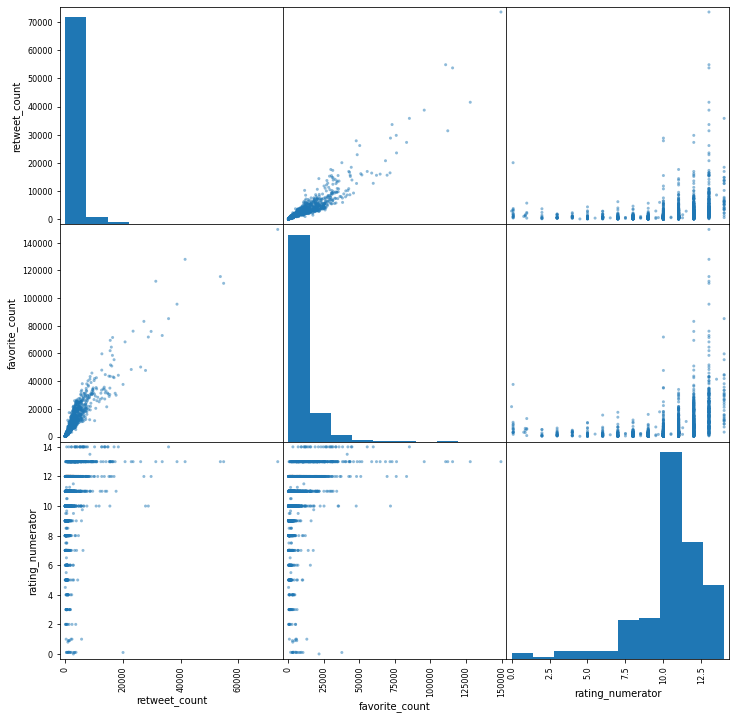

In [73]:
pd.plotting.scatter_matrix(df[['retweet_count', 'favorite_count', 'rating_numerator']], figsize=(12,12));

Visualized like this we see obvious correlations between __all of__ the three variables.

In [74]:
#we only look for tweets where first indication says that a dog was recognized
contains_dog = df.p1_dog == True
#print proportion of tweets where p1 was dog breed
df[contains_dog].shape[0]/df.shape[0]

0.7419683834778175

According to the algorithm only about 75% of the tweets are clearly showing a dog. At least on first prediction.
Let's have a look on the other ones.

In [75]:
df[~contains_dog].tail()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,dog_stage,full_text,truncated,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1939,666293911632134144,2015-11-16 16:37:02+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a funny dog. Weird toes. Won't come down. Loves branch. Refuses to eat his food. Hard to cuddle with. 3/10 https://t.co/IIXis0zta0,https://twitter.com/dog_rates/status/666293911632134144/photo/1,3.0,a,None,This is a funny dog. Weird toes. Won't come down. Loves branch. Refuses to eat his food. Hard to cuddle with. 3/10 https://t.co/IIXis0zta0,False,...,1.0,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False
1942,666268910803644416,2015-11-16 14:57:41+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Very concerned about fellow dog trapped in computer. 10/10 https://t.co/0yxApIikpk,https://twitter.com/dog_rates/status/666268910803644416/photo/1,10.0,None,None,Very concerned about fellow dog trapped in computer. 10/10 https://t.co/0yxApIikpk,False,...,1.0,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
1943,666104133288665088,2015-11-16 04:02:55+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/Asgdc6kuLX,https://twitter.com/dog_rates/status/666104133288665088/photo/1,1.0,None,None,Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/Asgdc6kuLX,False,...,1.0,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
1952,666057090499244032,2015-11-16 00:55:59+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",My oh my. This is a rare blond Canadian terrier on wheels. Only $8.98. Rather docile. 9/10 very rare https://t.co/yWBqbrzy8O,https://twitter.com/dog_rates/status/666057090499244032/photo/1,9.0,a,None,My oh my. This is a rare blond Canadian terrier on wheels. Only $8.98. Rather docile. 9/10 very rare https://t.co/yWBqbrzy8O,False,...,1.0,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
1954,666051853826850816,2015-11-16 00:35:11+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an odd dog. Hard on the outside but loving on the inside. Petting still fun. Doesn't play catch well. 2/10 https://t.co/v5A4vzSDdc,https://twitter.com/dog_rates/status/666051853826850816/photo/1,2.0,an,None,This is an odd dog. Hard on the outside but loving on the inside. Petting still fun. Doesn't play catch well. 2/10 https://t.co/v5A4vzSDdc,False,...,1.0,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False


According to the description and rating and after sample checks I assume that there are also dogs on the images that are just not recognized by the algorithm. So let's at least add the lower rate predictions if they predict a dog.

In [76]:
#get most probable dog breed in new column
def getMost_Probable_Dog_Breed(tweet):
    if tweet.p1_dog:
        return(tweet.p1)
    elif tweet.p2_dog:
        return(tweet.p2)
    elif tweet.p3_dog:
        return(tweet.p3)
    else:
        return(None)
        

df['most_probable_breed'] = df.apply(lambda x: getMost_Probable_Dog_Breed(x), axis=1)
consider_all_predictions = ~df.most_probable_breed.isnull()
df[consider_all_predictions].shape[0]/df.shape[0]

0.8454869964303927

In [77]:
#How many breeds are there in our newly created columns
df.most_probable_breed.nunique()

113

This enhances our recognized dog rate to around 85%.
As there are many different dog breeds we reduce our analysis to the top 10

In [78]:
#find top 10 recognized dog breeds only looking at p1
top10dogs = df[df.p1_dog].p1.value_counts().nlargest(10)
top10dogs

golden_retriever      136
Labrador_retriever     92
Pembroke               88
Chihuahua              78
pug                    54
chow                   41
Samoyed                39
Pomeranian             38
toy_poodle             36
malamute               29
Name: p1, dtype: int64

In [79]:
#find top 10 recognized dog breeds looking at p1-p3
top10dogs_all = df[consider_all_predictions].most_probable_breed.value_counts().nlargest(10)
dfi.export(top10dogs_all.to_frame(), './plots/Top_10_Dogs_in_dataset.png')
top10dogs_all

golden_retriever      155
Labrador_retriever    104
Pembroke               94
Chihuahua              90
pug                    62
toy_poodle             49
chow                   48
Pomeranian             41
Samoyed                41
malamute               33
Name: most_probable_breed, dtype: int64

This didn't affect results significantly. Let's go on working with the top10dogs_all list.

In [80]:
#find the top 10 recognized dog breeds mean rating
ratings_top10_dogs = df[df.p1.isin(top10dogs_all.keys())].groupby(['p1']).mean()['rating_numerator'].reindex(top10dogs_all.keys())

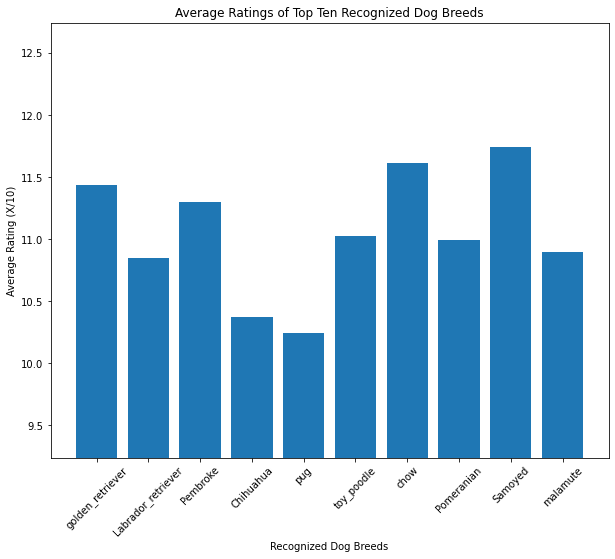

In [81]:
# Create a bar chart with proper label

def draw_Dog_Bar_Plot(data, title, xlabel, ylabel, ylim_offset):
    locations = np.arange(10)
    heights = data.values
    labels = data.keys()
    fig, ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(10)
    ax.set(ylim=(data.min()-ylim_offset, data.max()+ylim_offset))
    ax.set_xticks(locations)
    ax.set_xticklabels(labels, rotation=45, rotation_mode="default")
    ax.bar(locations, heights)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel);

draw_Dog_Bar_Plot(ratings_top10_dogs,
                  'Average Ratings of Top Ten Recognized Dog Breeds',
                  'Recognized Dog Breeds',
                  'Average Rating (X/10)',
                  1)

plt.savefig('./plots/average_rating_top10_breeds.png')

Based on the data we can now also have a look on favorite or retweet counts.

In [82]:
#find favorite count of top 10 recognized dog breeds
favoritecounts_top10_dogs = df[df.p1.isin(top10dogs_all.keys())].groupby(['p1']).mean()['favorite_count'].reindex(top10dogs_all.keys())
favoritecounts_top10_dogs

golden_retriever      11132.264706
Labrador_retriever    10292.891304
Pembroke              10164.056818
Chihuahua              7891.448718
pug                    5189.351852
toy_poodle             5756.972222
chow                   8896.024390
Pomeranian             7182.921053
Samoyed               11834.846154
malamute               7716.620690
Name: favorite_count, dtype: float64

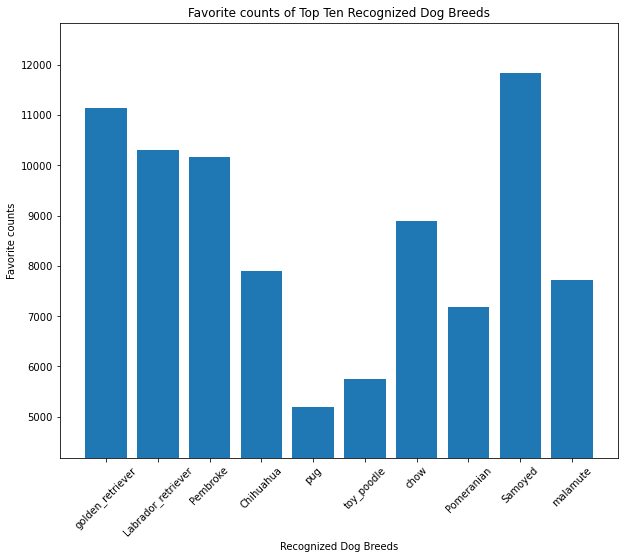

In [83]:
draw_Dog_Bar_Plot(favoritecounts_top10_dogs,
                  'Favorite counts of Top Ten Recognized Dog Breeds',
                  'Recognized Dog Breeds',
                  'Favorite counts',
                  1000)

plt.savefig('./plots/favorite_counts_top10_breeds.png')

In [84]:
retweetcounts_top10_dogs = df[df.p1.isin(top10dogs_all.keys())].groupby(['p1']).mean()['retweet_count'].reindex(top10dogs_all.keys())
retweetcounts_top10_dogs

golden_retriever      3107.000000
Labrador_retriever    3213.010870
Pembroke              2683.352273
Chihuahua             2429.987179
pug                   1518.981481
toy_poodle            2054.916667
chow                  2417.951220
Pomeranian            2382.736842
Samoyed               3763.538462
malamute              2138.862069
Name: retweet_count, dtype: float64

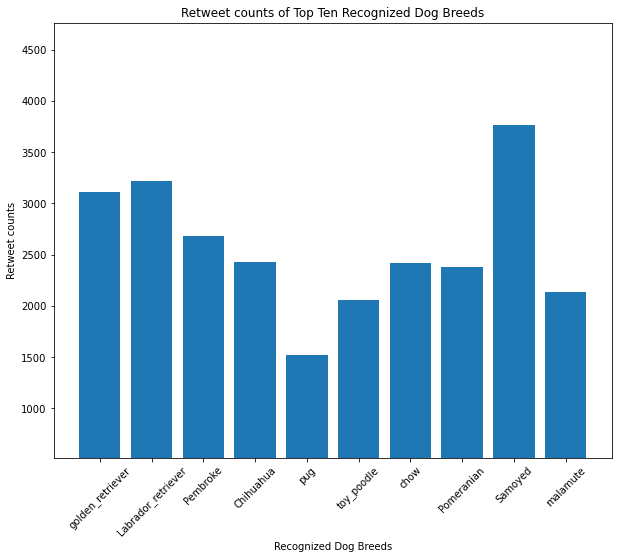

In [85]:
draw_Dog_Bar_Plot(retweetcounts_top10_dogs,
                  'Retweet counts of Top Ten Recognized Dog Breeds',
                  'Recognized Dog Breeds',
                  'Retweet counts',
                  1000)

plt.savefig('./plots/retweets_counts_top10_breeds.png')

In [86]:
 Question: Is there a correlation between favorite counts and rating?

Object `rating` not found.


Question: Is there a correlation between favorite counts and rating

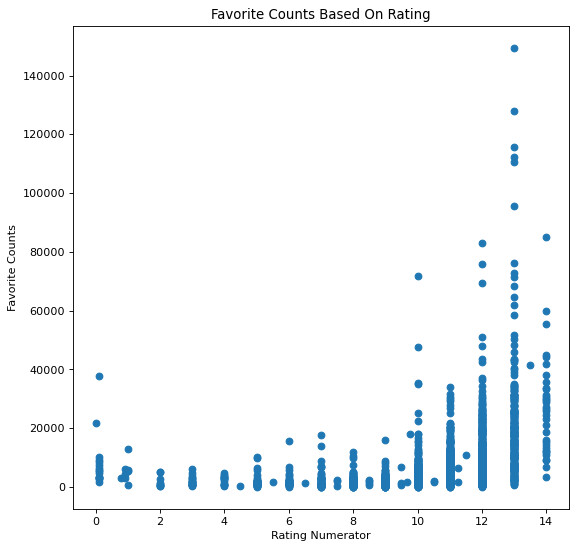

In [87]:
plt.figure(figsize=(8, 8), dpi=80)
plt.title('Favorite Counts Based On Rating')
plt.xlabel('Rating Numerator')
plt.ylabel('Favorite Counts')
plt.scatter(df['rating_numerator'], df['favorite_count']);

plt.savefig('./plots/favorite_counts_based_on_rating.png')

As the digram indicates a correlation I'm going to look at its significance using a linear regression model.

In [88]:
df['intercept'] = 1

lm = sms.OLS(df['favorite_count'], df[['intercept', 'rating_numerator']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         favorite_count   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     300.4
Date:                Wed, 12 May 2021   Prob (F-statistic):           1.00e-62
Time:                        13:03:10   Log-Likelihood:                -21025.
No. Observations:                1961   AIC:                         4.205e+04
Df Residuals:                    1959   BIC:                         4.206e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept        -1.077e+04   1110.663     -9.694      0.000   -1.29e+04   -8588.628
rating_numerator  1797.8357    103.727     17.332      0.000    1594.409    2001.263
==============================================================================
Omnibus:                     1922.954   Durbin-Watson:                   1.500
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           112434.153
Skew:                           4.633   Prob(JB):                         0.00
Kurtosis:                      38.919   Cond. No.                         48.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-value (0.0) indicates that this correlation is statistically significant

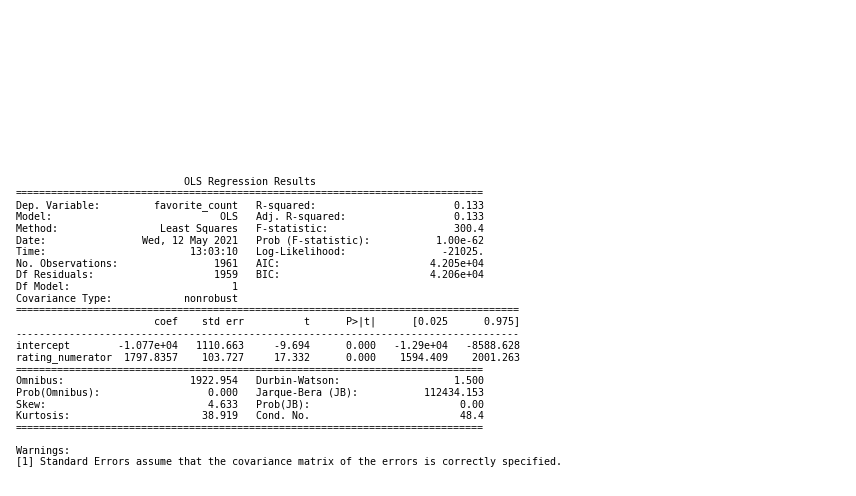

In [89]:
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(results.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()

plt.savefig('./plots/OLS_regression_output.png')

## Conclusion

We were looking at recognized dog breeds and saw which breeds get higher ratings, favorite and retweet counts.
Additionally we looked on the correlation between rating and favorite counts. 
Based on the data there is a significant correlation between the two.

Limitations:
* As there are many different dog breeds, value counts for each breed are relatively small (33-155 individual tweets per dog breed) - all observations are therefore limited
* A central assumption concerning the dog breed was that the image recognition algorithm is reliable. I didn't double check on this, so this may also have significant impact on the result.